In [1]:
import numpy as np
import scipy.stats as st
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as av
import pymc3 as pm
import theano as th
import theano.tensor as tt

In [422]:
# Estimation on a subset of Alternatives

np.random.seed(31)
n_alternatives = 100 # or 2^7
n_params = 7
n_choices = 3
n_decision_makers = 1000

beta_trues = np.random.randint(-7, 7, size=n_params)
beta_trues

array([-5,  0, -7, -5,  0,  3,  5])

In [423]:
all_alternative_features = []
for i in range(n_alternatives):
    features = map(int, np.binary_repr(i, width = n_params))
    all_alternative_features.append(list(features))
    
all_alternative_features = np.vstack([np.zeros((1, n_params)), np.random.permutation(all_alternative_features[1:])])

In [428]:
main_shares = np.array([0.3, 0.2, 0.15, 0.15, 0.1])
other_shares = np.random.dirichlet(np.ones(n_alternatives - 5), size=1).squeeze() * 0.1

market_shares = np.hstack((main_shares, other_shares))

In [ ]:
ax.xaxis.set_visible(False)

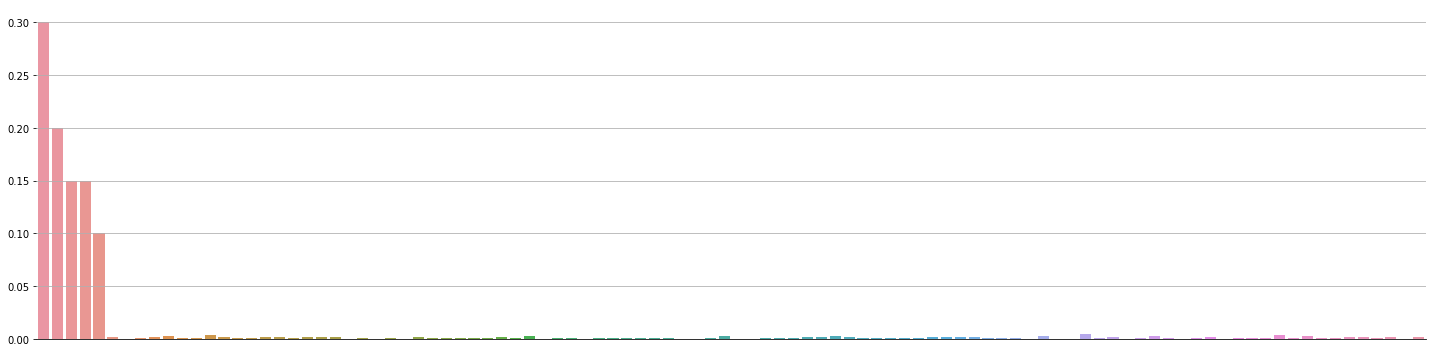

In [448]:
f, ax = plt.subplots(figsize=(20, 5))
sns.barplot(np.arange(market_shares.shape[0]), market_shares)
plt.grid()
sns.despine(left=True)
ax.xaxis.set_visible(False)
plt.tight_layout()
plt.savefig("../../../sidravi1.github.io/assets/20191120_market_shares.png")

In [381]:
probability_of_picked = market_share

In [385]:
# Calculate utilities and the item chosen
utilities = all_alternative_features @ beta_trues + np.random.gumbel(0, 2, size=(n_decision_makers, n_alternatives))

# index of the item chosen
idx_chosen = np.argmax(utilities, axis=1)

# given this id has been chosen, let's pick other options
choice_sets = []
for i in range(n_decision_makers):
    id_chosen = idx_chosen[i]
    prob = probability_of_picked.copy()
    prob[id_chosen] = 0
    prob = prob / prob.sum()
    
    other_alternatives = np.random.choice(np.arange(n_alternatives), size = 3, replace = False, p = prob)
    choice_set = np.hstack((id_chosen, other_alternatives))
    choice_sets.append(choice_set)
    
choice_sets = np.array(choice_sets)

In [386]:
choice_set_features = np.apply_along_axis(lambda x: all_alternative_features[x], 1, choice_sets)

In [387]:
def q_K(K, probs):
    if len(K) == 0:
        return 1
    else:
        total = 0
        for x in K:
            val, probs_new = prob(x, probs)
            total += val * q_K(K[K!=x], probs_new)
        return total
    
def prob(x, probs):
    probs_new = probs.copy()
    val = probs_new[x]
    probs_new[x] = 0
    probs_new = probs_new / probs_new.sum()
    return val, probs_new

def q_Ki(i, K, probs):
    
    probs_copy = probs.copy()
    probs_copy[i] = 0
    probs_copy = probs_copy / probs_copy.sum()
    
    return q_K(K[K != i], probs_copy)

In [388]:
q_Ki_vec = np.vectorize(q_Ki, excluded=set(["K", "probs"]))

In [390]:
qK_i_matrix = []
probability_of_picked_no_oo = probability_of_picked.copy()

for i in range(n_decision_makers):
    qKi_prob = q_Ki_vec(i = choice_sets[i, :].copy(), K = choice_sets[i, :].copy(), probs = probability_of_picked.copy())
    qK_i_matrix.append(qKi_prob)

qK_i_matrix = np.array(qK_i_matrix)

In [391]:
#qKi_oo = np.repeat(1 / sp.special.comb(n_alternatives - 1, n_choices - 1), n_decision_makers).reshape(-1, 1)
#qKi_matrix_oo = np.hstack((qKi_oo, qKi_matrix))

ln_qKi_matrix = np.log(qK_i_matrix)
ln_qKi_matrix

array([[ -2.54033976, -71.33598706, -71.44248803, -70.44967683],
       [ -2.40474601,  -3.02198712,  -2.00737491,  -3.11617137],
       [ -2.21689612, -14.39471235, -13.64990081, -14.29218369],
       ...,
       [ -3.34948135,  -4.08189949,  -3.9825171 ,  -2.13522858],
       [ -2.91701188, -55.26259245, -56.45919177, -56.56885091],
       [ -4.5560723 , -72.51178809, -73.66124155, -72.32895189]])

In [392]:
choice = np.zeros((n_decision_makers, n_choices + 1))
choice[:, 0] = 1

In [400]:
def plot_results(trace, beta_true, ax=False, xlim = None):
    
    if ax is False:
        f, ax = plt.subplots(figsize=(7,10))
    ys = np.arange(beta_true.shape[0])
    xs_true = beta_true
    
    xs_pred_mean = trace.mean(axis=0)
    xs_pred_low, xs_pred_high = np.percentile(trace, q=[2.5, 97.5], axis=0)
    
    ax.plot(xs_true, ys, ".r", ms=10, label='actual')
    ax.hlines(ys, xmin=xs_pred_low, xmax=xs_pred_high, zorder=-1)
    ax.scatter(xs_pred_mean, ys, facecolors='lightblue', edgecolors='k', s=80, label='estimate')
    ax.set_yticks(np.arange(0, len(beta_true) + 1))
    ax.axvline(x=0, ls=":")
    ax.set_ylabel("Betas")
    if xlim != None:
        ax.set_xlim(xlim)
    ax.legend(loc=2)
    
    ax.grid(True)
    plt.tight_layout()

    sns.despine(left=True)
    return ax

In [393]:
with pm.Model() as m_sampled:
    
    betas_rest = pm.Normal('betas', 0, 1, shape=n_params)
    V = tt.dot(choice_set_features, betas_rest) 
    p = tt.nnet.softmax(V)
    
    pm.Multinomial('ll', n=1, p=p, observed = choice)

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [394]:
trace = pm.sample(model=m_sampled, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:07<00:00, 830.49draws/s]


In [395]:
pm.summary(trace)

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betas__0,-0.208898,0.287584,0.006138,-0.753614,0.371185,2290.139756,0.999630
betas__1,-1.623565,0.154082,0.004015,-1.916060,-1.326226,1458.137605,1.001837
betas__2,-2.189662,0.249639,0.006064,-2.657234,-1.711977,1714.230399,1.000148
betas__3,-0.745552,0.212170,0.005452,-1.144861,-0.336415,1714.071931,1.002022
betas__4,1.599283,0.154445,0.003794,1.323121,1.926336,1814.459322,1.001321
betas__5,2.321646,0.154059,0.003836,2.050019,2.651339,1494.454492,1.001835
betas__6,3.523610,0.180668,0.004337,3.172816,3.869370,1733.352564,1.001102


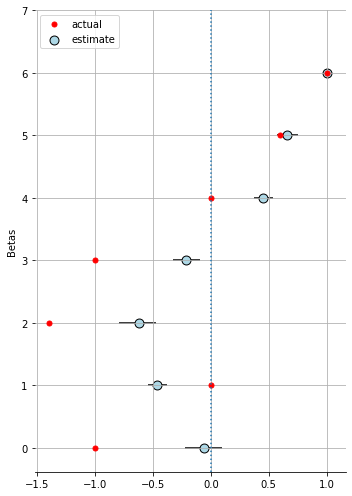

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [454]:
scaled_trace = trace['betas'].squeeze()
scaled_trace = scaled_trace / scaled_trace[:, 6].reshape(-1, 1)
f, ax = plt.subplots(figsize=(5, 7))
ax = plot_results(scaled_trace, beta_trues/beta_trues[6], ax=ax)

In [397]:
with pm.Model() as m_sampled_reweighted:
    
    betas_rest = pm.Normal('betas', 0, 3, shape=n_params)
    V = tt.dot(choice_set_features, betas_rest) + ln_qKi_matrix
    p = tt.nnet.softmax(V)
    
    pm.Multinomial('ll', n=1, p=p, observed = choice)

In [398]:
trace_weighted = pm.sample(model=m_sampled_reweighted, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:09<00:00, 648.66draws/s]


In [405]:
pm.summary(trace_weighted) 

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betas__0,-2.742069,0.676398,0.022862,-4.008849,-1.358905,776.431438,1.000177
betas__1,-0.090493,0.481142,0.018686,-1.041471,0.821605,533.409645,1.002408
betas__2,-3.915034,0.660634,0.014861,-5.263927,-2.655540,2071.603273,0.999461
betas__3,-2.874134,0.523170,0.011586,-3.910821,-1.855000,1614.724560,0.999807
betas__4,-0.118848,0.371304,0.013677,-0.825895,0.601821,599.859685,1.002042
betas__5,1.431561,0.450185,0.017340,0.607397,2.302195,553.442880,1.002533
betas__6,2.318829,0.314854,0.009962,1.727227,2.964246,860.158141,1.002235


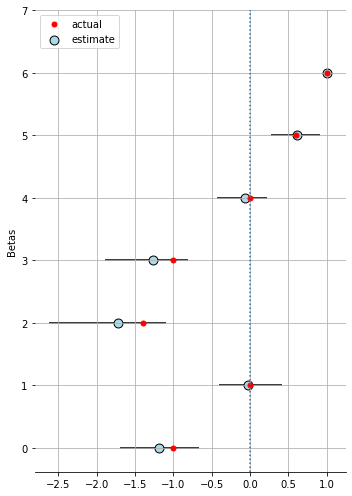

In [452]:
scaled_trace = trace_weighted['betas'].squeeze()
scaled_trace = scaled_trace / scaled_trace[:, 6].reshape(-1, 1)
f, ax = plt.subplots(figsize=(5, 7))
ax = plot_results(scaled_trace, beta_trues/beta_trues[6], ax=ax)
plt.savefig("../../../sidravi1.github.io/assets/20191120_results.png")